<a href="https://colab.research.google.com/github/daria-nikanorova/Movies_Recommender/blob/master/Movies_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative filtering vs Hybrid recommender

This project is aimed at building and comparing recommender systems. Usually, there are two approaches for recommending some items to users : Collaborative Filtering (CF) and Content-Based

The first one - collaborative filtering - is based only on information about explicit or implicit interactions between users and items, such as ratings, tags, clicks etc. One of the most popular methods for collaborative filtering is based on singular value decomposition (SVD).

In contrast, content-based recommender systems take into account not only history of interactions but also additional information about users or items. For example, if two users are of the same age and have similar jobs, we can assume that they have also common preferencies in music, movies etc. Similarly, two movies of the same genre are more likely to be highly estimated by a user.

Hybrid systems try to use both information about interactions between users and items as well as additional item or user features.

We will use *movielens-20m-dataset*, which contains information about ~20 mln of ratings from Netflix website.

The first part of this notebook is fully dedicated to build collaborative filtering recommender with *Surprise* library. The second part is concerned with comparing collaborative and hybrid approaches using *LightFM* library. 

## Retrieving the data

First of all we need to install all libraries and obtain data. It is very convenient to download it directly from Kaggle, mounting on Google drive. 

You may skip this part in case you are not interested in technical details of obtaining data.

In [2]:
#Install packages

!pip install surprise -qq
!pip install -qq kaggle
!pip install -qq dask[complete]
!pip install -qq lightfm
!pip install -qq scikit-optimize

     |████████████████████████████████| 11.8MB 6.3MB/s 
     |████████████████████████████████| 727kB 6.0MB/s 
     |████████████████████████████████| 122kB 10.6MB/s 
ERROR: distributed 2021.6.2 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.6.2 has requirement dask==2021.06.2, but you'll have dask 2.12.0 which is incompatible.
     |████████████████████████████████| 317kB 4.9MB/s 
     |████████████████████████████████| 102kB 4.5MB/s 


In [49]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import GridSearchCV, cross_validate, KFold 
from surprise.dump import dump, load
from google.colab import files
from scipy.sparse import csr_matrix
import csv
import dask.dataframe as dd
from scipy import sparse
from collections import defaultdict

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split

from sklearn.model_selection import train_test_split
from skopt import forest_minimize

from scipy.stats import ttest_ind

In [46]:
# Set parameters for all future graphs

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.size'] = 20

We need to upload kaggle.json key in order to obtain data (you can get the key in your kaggle profile and upload via files.upload())

In [ ]:
files.upload()

Now we will:
* copy kaggle key in kaggle directory
* download data
* make directory on Gooogle drive
* unzip files

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d grouplens/movielens-20m-dataset
! mkdir drive/MyDrive/movielens_data/
! unzip movielens-20m-dataset.zip -d drive/MyDrive/movielens_data/

That's it!

OK, having obtained the data we now can take a look at it.

## Long Tail plot

But firstly let me show you why we need to create a recommender system.

Let's find out how many movies are rated by the most users.

In [60]:
df = pd.read_csv("drive/MyDrive/movielens_data/rating.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [61]:
volume_df = df['movieId'].value_counts().reset_index()
volume_df.columns = ['movieId', "volume"]
volume_df.head()

,movieId,volume
0,296,67310
1,356,66172
2,318,63366
3,593,63299
4,480,59715


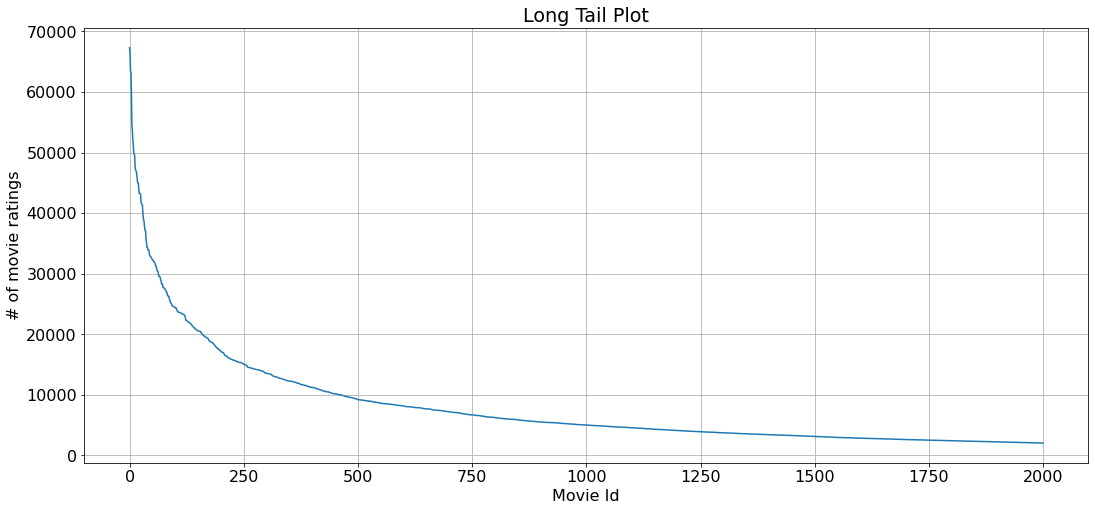

In [62]:
# Make a plot
xs = range(0, 2000)
ys = volume_df['volume'][:2000]

plt.plot(xs, ys)

plt.title('Long Tail Plot')

plt.xlabel('Movie Id')
plt.ylabel('# of movie ratings')

plt.grid()

The plot above is called "Long Tail plot".

Typically, only a small percentage of items have a high volume of interactions, and this is referred to as the “head”. Most items are in the “long tail”, but they only make up a small percentage of interactions.

Indeed, there are less than 500 movies that were rated more than 10000 times. These movies are already well-known to most users, and recommendations of them may not offer a personalized experience or help users discover new, relevant movies.  

That is why we need to build a powerful recommender system that will recommend movies based on user's own preferencies as well as popularity and movies features.

## Train/test split

Apart from ratings there are timestamps in the data. Brilliant, we can use it for splitting data.

Imagine working in Netflix: you had already deployed recommendation system, but new data arrived after that! So you need to include new movies (or users) in your recommendation system. Are you sure your model is appropriate to work with absolutely new data?

We can simulate this situation and train our models on old data, following by testing on new data.

The idea is to take 33% of most recent ratings from each user as a test datset, using left part (old ratings) as a training set.

In [63]:
# Sort the data by userId and time of his ratings

df_sorted = df.sort_values(by=["userId", "timestamp"], ascending = (True, False))

In [64]:
# Create a dataframe with information about a number of ratings and 33% of it for each user

# Calculate a number of ratings for each user
users_count = pd.DataFrame(df_sorted['userId'].value_counts(sort=False)).reset_index()
users_count.columns = ['userId', "n_of_ratings"]
users_count = users_count.sort_values(by="userId")

# Calculate cumulative sum of number of ratings across all users
users_count['cum_n_of_ratings'] = users_count['n_of_ratings'].cumsum()

# Find 33% of ratings for each user
users_count['n_of_ratings_33'] = round(users_count['n_of_ratings'] * 0.33).astype(int)
users_count

,userId,n_of_ratings,cum_n_of_ratings,n_of_ratings_33
8,1,175,175,58
17,2,61,236,20
26,3,187,423,62
35,4,28,451,9
44,5,66,517,22
...,...,...,...,...
66193,138489,38,19999635,13
66184,138490,151,19999786,50
66175,138491,22,19999808,7
66236,138492,82,19999890,27


After that we can find indices that are correspondent to 33% of the most recent ratings in our sorted dataframe.

In [ ]:
# Add index for the 1st user manually
test_ind = list(range(59))

# Loop over all users and add index
for i in range(1, n_users):
  start = users_count.iloc[i-1, 2]
  stop = start + users_count.iloc[i, 3] + 1
  for _ in range(start, stop):
    test_ind.append(_)

OK, now lets find index of the train data (~66%)

In [ ]:
n_of_ratings = df.shape[0]

train_ind = np.setdiff1d(list(range(n_of_ratings)), test_ind)

Now we only need to get rows from the initial dataframe according to the indices we've found:

In [ ]:
test_data = df_sorted.iloc[test_ind]

In [ ]:
train_data = df_sorted.iloc[train_ind]

In [ ]:
#test_data.to_csv('drive/MyDrive/movielens_data/test_manually.csv', index=False)
#train_data.to_csv('drive/MyDrive/movielens_data/train_manually.csv', index=False)

Of course it is more convenient to use pandas tools, like groupby and others, but pandas turned out to be very slow on the data with ~20 mln rows!

## Which metric should I choose?

Before starting to fit models we need to choose a metric for model evaluation.

There are lots of metrics to choose from, but in terms of recommender systems, the most popular ones are Precision at k (precision@k) and Recall at k (recall@k).

In short, precision@k, similarly to its classic implementation, is the fraction of relevant items in *k* retrieved items. It is used to answer how many items among *k* recommendations are correct.

And recall@k is the fraction of relevant items in all relevant items. It is to answer how many from all relevant items are captured in the recommendations.

To my mind, precision@k is more relevant. Imagine a user, who wants to watch a movie and asks for recommendation. For example, your system recommends 10 movies, 9 of them are highly relevant to a user. A user becomes very happy and will defenitely rely on your system in the future. However your system did not find all relevant movies - lot's of them remain unrecommended to your user. Fortunately, a user will never know that! He is happy with the fact that 9 out of 10 movies were brilliant. 

By contrast, if you try to find as much relevant movies as possible, you will end up recommending a lot of trash movies along with good ones. Your user will soon be disappointed, because he spent a lot of time watching inappropriate movies.

That is why I dicided to use precision@k.

## I. Collaborative filtering

After splitting data into train and test we can apply SVD algorithm implemented in *surprise* library. 

Model-based Collaborative Filtering can be formulated by approximating a matrix by using Singular Value Decomposition (SVD).

Imagine we have a sparse user-item matrix (m×n): each column represents an item, each row - a user. We can decompose such matrix *R* into three:

* *U* matrix (m×r)
* *S* diagonal matrix (r×r)
* *V transpose* (r×n)

The first matrix represents all users, the last one - all items. Than we can easily find a value in in our user-item matrix as a dot product between a row from *U* matrix and a column from *Vt* matrix. 

This approach has a simple underlying intuition: we can predict a rating of a user *u* to the movie *m*, knowing how other users rate this movie *m* and how user *u* usually estimated other movies.

Unfortunately, we cannot have missing values in our matrix before decomposition...

That is why we need machine learning! We cannot precisely find the decomposition, but we can try to fill missing values in a way that will describe our initial data as close as possible.

We will use Root Mean Square Error (RMSE) for optimization and we can implement stochastic gradient descent in order to find the minimum of this function during learning.

Exactly the same approach is implemented in *Surprise* library. So we will start from fitting SVD model with default parameters. After that we will tune learning rate and regularization parameters with *GridSearchCV* function. Finally, we will define optimal number of epochs for training.

With all parameters estimated we will fit the best model and make predictions on test data.

### Load data

Upload test and train data using *dask* library:

In [64]:
train = dd.read_csv("drive/MyDrive/movielens_data/train_manually.csv")
test = dd.read_csv("drive/MyDrive/movielens_data/test_manually.csv")

In [65]:
# check if the data are correct:
train.head()

,userId,movieId,rating,timestamp
0,1,2872,4.0,2005-04-02 23:48:17
1,1,8368,4.0,2005-04-02 23:48:08
2,1,8961,4.0,2005-04-02 23:47:09
3,1,2947,3.5,2005-04-02 23:46:20
4,1,223,4.0,2005-04-02 23:46:13


In [66]:
# set reader object to load dataframe
reader = Reader(rating_scale=(1, 5))

In [67]:
# load dataframe
train_data = Dataset.load_from_df(train[["userId", "movieId", "rating"]], reader)
test_data = Dataset.load_from_df(test[["userId", "movieId", "rating"]], reader)

### Fit SVD with default parameters

In [35]:
# we'll use SVD algorithm with default parameters firstly
algo = SVD()

In [36]:
# Run 3-fold cross-validation and print results
cross_validate(algo, train_data, measures=['RMSE'], cv=3, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8159  0.8161  0.8156  0.8159  0.0002  
Fit time          541.85  565.83  554.54  554.07  9.80    
Test time         120.57  94.69   90.32   101.86  13.35   


{'fit_time': (541.8450000286102, 565.8299915790558, 554.5419628620148),
 'test_rmse': array([0.81587397, 0.8161467 , 0.81557396]),
 'test_time': (120.57368755340576, 94.68907237052917, 90.3227641582489)}

We achieved test RMSE of 0.8159. That is good, but couldn't we do better with tuning some parameters?

### Parameters tuning

We've applied SVD algorithm with default parameters, but we can actually set the best parameters using *GridSearcCV* function. The most important parameters for SVD are learning rate and regularization parameter.

In [ ]:
# set parameters for search
param_grid = {
    "reg_all": [0.02, 0.4, 0.6],
    "lr_all": [0.002, 0.005, 0.01]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)

In [ ]:
# find best parameters
gs.fit(train_data)

In [ ]:
print(gs.best_params['rmse'])

{'reg_all': 0.02, 'lr_all': 0.005}


Interestingly, the best parameters are the same ones that are implemented in default SVD(). OK, now we are sure about that.

In [ ]:
# retrieve dataframe with metrics for each pair of parameters and save it
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.to_csv('drive/MyDrive/movielens_data/svd_trained_3_reg_lr_metrics.csv', index=False)

We can dump our fitted algorithm for further analysis.

In [ ]:
algo = gs.best_estimator['rmse']
dump('drive/MyDrive/movielens_data/svd_trained_3_reg_lr', algo=algo)

The process of tuning is not over yet. We need to set the optimal time for learning - the number of epochs.  

### Convergence vs overfitting

Ideally, at some point the RMSE becomes 0, and we know we cannot do better. On practice we rarely can achieve zero error. Usually, the model is considered to be converged when loss function (RMSE in our case) begin to fluctuate over a minimum with the tiniest difference. In other words, we can stop
when the improvement falls below a threshold. That means that the minimum of function was found, and further learning will not improve the result.

However, we are not sure that the minimum we've found is global. Actually, we can arrive at one of the local minima that conform well to the train data, but
doesn't reflect testing data. Although the RMSE may be small on the training
data, it doesn’t predict well future data.

That is why it is important to measure RMSE loss in validation data as well. Without that finding minimum in training data may lead to overfitting: excellent predictions in training data and poor ones in the test data.

In order to find optimal number of epochs we will again use *GridSearchCV* with cross-validation. For each epoch we will split train set into 3 parts: the first two are the trainig data, and the last serves as validation data. Then we will repeat the same 3 times: each time the validation set will be new. We will get mean RMSE for training data as well as mean test RMSE.

In [ ]:
param_grid = {
    "n_epochs": [1, 5, 10, 20, 50, 75]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3, return_train_measures=True, joblib_verbose=3)

In [ ]:
gs.fit(train_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 16.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 29.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 38.9min remaining:    0.0s


In [11]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df

,split0_test_rmse,split0_train_rmse,split1_test_rmse,split1_train_rmse,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs
0,0.906740,0.895792,0.905689,0.896836,0.906214,0.000526,0.896314,0.000522,6,24.711922,0.034642,92.561041,8.469337,{'n_epochs': 1},1
1,0.876854,0.847135,0.875632,0.847665,0.876243,0.000611,0.847400,0.000265,5,99.901261,0.435135,79.933525,0.380520,{'n_epochs': 5},5
2,0.854499,0.792938,0.853356,0.792667,0.853928,0.000571,0.792802,0.000135,3,200.418372,0.960459,90.312848,1.873426,{'n_epochs': 10},10
3,0.833860,0.664740,0.832901,0.664717,0.833380,0.000479,0.664729,0.000011,1,401.893433,1.365015,81.224548,1.464715,{'n_epochs': 20},20
4,0.847991,0.461543,0.847106,0.461358,0.847548,0.000442,0.461450,0.000092,2,1001.916416,3.054916,86.736623,8.329652,{'n_epochs': 50},50
5,0.855660,0.410124,0.854789,0.409965,0.855225,0.000436,0.410044,0.000080,4,1501.513762,3.481090,83.090090,7.338289,{'n_epochs': 75},75


Let's visualize the results in order to find best number of epochs:

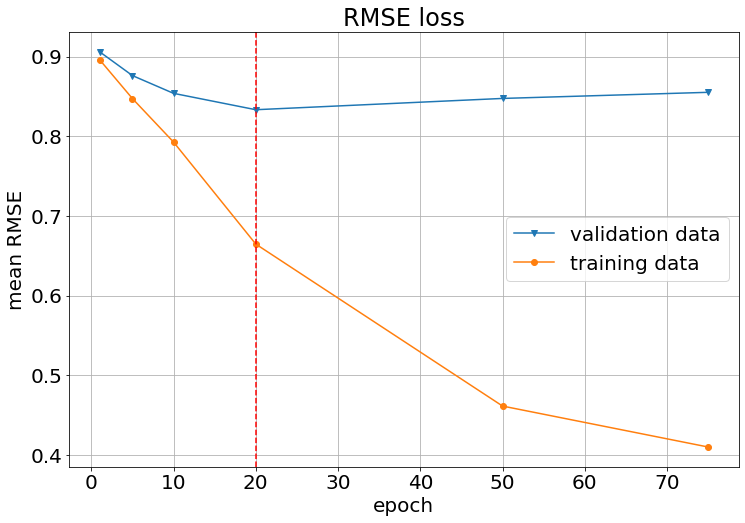

In [25]:
# set axes
xs = results_df['param_n_epochs']
ys1 = results_df['mean_test_rmse']
ys2 = results_df['mean_train_rmse']

# plot axes
plt.plot(xs, ys1, marker='v', label = 'validation data')
plt.plot(xs, ys2, marker='o', label = 'training data')

# plot vertical line
plt.axvline(x=20, color="red",  linestyle='--')

# add title and labels
plt.title('RMSE loss')
plt.xlabel('epoch')
plt.ylabel('mean RMSE')

# add legend
plt.legend()

# add grid
plt.grid()
#plt.savefig('drive/MyDrive/movielens_data/RMSE_loss_svd.png')

According to the plot, RMSE decreases steadily for training data. However, in terms of vaidation data, RMSE falls down only during first 20 epochs. After that it begins to grow again! 

It means that learning more than for 20 epochs will lead to overfitting. 

So we've found out that the best parameters are:
* regularization: 0.02 
* learning rate: 0.005
* number of epochs: 20

Having found all best parameters, we can now fit SVD algorithm on training data and make predictions on testset.

### Predictions on the test data

Let's fit a new model with the best parameters:

In [72]:
algo = SVD(reg_all=0.02, lr_all=0.005, n_epochs=20)

In [38]:
# retrain on the training set
trainset = train_data.build_full_trainset()
algo.fit(trainset)

In [39]:
# Compute biased accuracy on the training set
predictions = algo.test(trainset.build_testset())
print('Biased accuracy on A,', end=' ')
accuracy.rmse(predictions)

Biased accuracy on A,   RMSE: 0.6738


0.6737622973261234

Now we can evaluate the model on the test set and make predictions on it.

In [40]:
# Compute unbiased accuracy on the test set
testset = test_data.build_full_trainset().build_testset()
predictions = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)

Unbiased accuracy on B, RMSE: 0.8177


0.8177261309021537

In [75]:
predictions_df = pd.DataFrame.from_dict(predictions)

In [76]:
predictions_df

,uid,iid,r_ui,est,details
0,1,1750,3.5,2.521167,{'was_impossible': False}
1,1,3997,3.5,2.340072,{'was_impossible': False}
2,1,4133,3.0,2.501212,{'was_impossible': False}
3,1,7449,3.5,2.526362,{'was_impossible': False}
4,1,1525,3.0,2.455482,{'was_impossible': False}
...,...,...,...,...,...
6742242,138493,5992,5.0,4.430670,{'was_impossible': False}
6742243,138493,47465,5.0,4.558958,{'was_impossible': False}
6742244,138493,52975,4.0,4.116451,{'was_impossible': False}
6742245,138493,26422,5.0,4.499306,{'was_impossible': False}


Looks great! But we decided to use precision@k metric for evaluation.

### Precision@k and recall@k

In [74]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

Firstly let's calculate precision and recall during cross-validation. We will use only train_data, with old ratings for this step:

In [90]:
columns = ['precision', 'recall']
result = pd.DataFrame(columns=columns)

# define a cross-validation iterator
kf = KFold(n_splits=10)

for trainset, testset in kf.split(train_data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    precisions, recalls = precision_recall_at_k(predictions)
    mean_precision = sum(prec for prec in precisions.values()) / len(precisions)
    mean_recall = sum(rec for rec in recalls.values()) / len(recalls)

    fold_result = pd.DataFrame([[mean_precision, mean_recall]], columns=columns)
    result = result.append(fold_result, ignore_index=True)

In [68]:
result

,precision,recall
0,0.689850,0.630193
1,0.691631,0.629676
2,0.691589,0.630832
3,0.691766,0.630595
4,0.691525,0.630612
5,0.690433,0.629706
6,0.690518,0.629065
7,0.691800,0.629853
8,0.692306,0.629846
9,0.690642,0.629902


In [71]:
print("Average precision: ", result.precision.mean())
print("Average recall: ", result.recall.mean())

Average precision:  0.6912061599098865
Average recall:  0.6300279085932925


Precision is quite high, and very close to recall. Let's check it now predictions from the test data with new ratings!

In [44]:
precisions, recalls = precision_recall_at_k(predictions)

In [ ]:
precisions_df = pd.DataFrame.from_dict(precisions.values())
recalls_df = pd.DataFrame.from_dict(recalls.values())
prec_rec = pd.concat([precisions_df, recalls_df], axis=1)
prec_rec.columns = ['precision', "recall"]

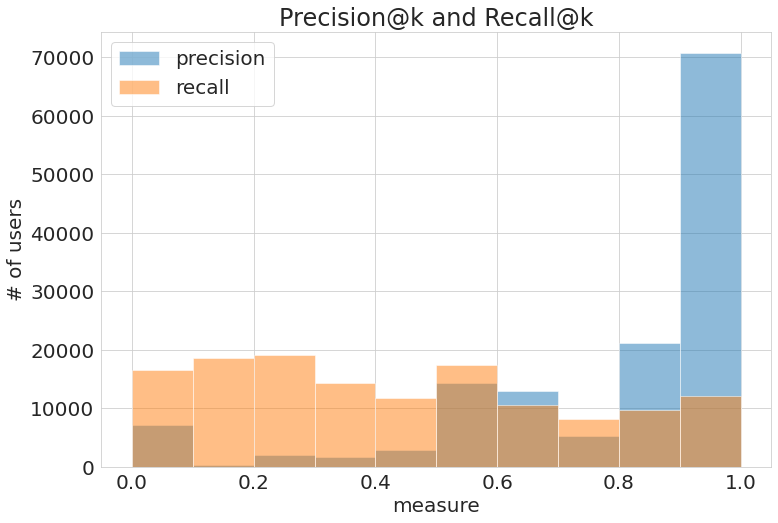

In [97]:
plt.hist(prec_rec.precision, alpha=0.5, label='precision')
plt.hist(prec_rec.recall, alpha=0.5, label='recall')

# add title and labels
plt.title('Precision@k and Recall@k')
plt.xlabel('measure')
plt.ylabel('# of users')

plt.legend(loc='upper left')

In [45]:
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.7864816988629639
0.4384171485771893


The precision score is higher on the test data! It may be due to the fact that the function implies that an item is considered relevant if its true rating is greater than a given threshold. And we give a threshold of 3.5. Maybe in our test data mean rating is higher than in old, training data? It can lead to a larger number of candidate movies to include in top 10 movies for recommendation. It will also explain lower recall: if we have lot's of good candidates, we cannot take them all, we need to select only 10 of them! 

By the way, how does our model deal with new data? We know that in testing data there are some new movies, that were not rated before.

According to *Surprise* documentation:
*"The algorithms in surprise don't have a fallback to specifically handle cold start but some (e.g. SVD) will naturally fallback to the mean of the ratings if there are no user-wise or item-wise info available".*

That's it - the model simply give a new item an average rating.

Is it correct? Shouldn't we take into account some additional information about new items or users in order to recommend them at the very beginning, when no ratings were collected?

Indeed, it's a hybrid approach, and we can test it with the *LightFM* library.

### Hybrid approach

Firstly we need to construct datasets for calculation. It's not quite obvious step - good part of LightFM githab issues are aimed at problems with data managing - so I will explain some crucial details.

As I have stated before, we use old ratings as training set and new ratings as a test set. Firstly we need to construct dataset that will contain **all** users and movies (old and new), even if there is now interaction between them.

In our case all users and all movies are in one initial dataset *ratings.csv*

In [4]:
# Upload initial ratings data
all_ratings = pd.read_csv("drive/MyDrive/movielens_data/rating.csv")

In [33]:
# We call fit to supply all userid and movie id
dataset_all = Dataset()
dataset_all.fit(
        all_ratings['userId'].unique(), # all the users
        all_ratings['movieId'].unique(), # all the items
)

We now upload old and new data, splitted before by the date of rating.

In [6]:
old_ratings = pd.read_csv("drive/MyDrive/movielens_data/train_manually.csv")
new_ratings = pd.read_csv("drive/MyDrive/movielens_data/test_manually.csv")

IMPORTANT PART: Now we need to build interactions (simply build item-user sparse matrix) for **both** old and new data separately, using all data as a template.

How our matrices will look like? As you may guess, they will contain interactions only from old or new data and zeros where no interaction was found. For example, new movie from new data will have its own column in both matrices: with interactions in new one and zeros in old one.

It is crucial for further model fitting, because in LightFM it is impossible to present new item or user ids to a model. However, we may build predictions for new item or user with already fitted model - and that is why we use hybrid system. 

We will discuss this later.

In [34]:
# plugging in the interactions and their weights
interactions_old, weights_old = dataset_all.build_interactions([(x[0], x[1], x[2]) for x in old_ratings.values])

In [35]:
# plugging in the interactions and their weights
interactions_new, weights_new = dataset_all.build_interactions([(x[0], x[1], x[2]) for x in new_ratings.values])

That's it! Now we can start fit the models. We will build three of them: the baseline model based on collaborative filtering only, the baseline with optimal parameters and the hybrid model, which will based on ratings as well as additional information about movies.

## Baseline model

Firstly we fit a model for collaborative filtering. It will be based only on ratings information. However, it will pay attention also to implicit ratings. Explicit ratings (used in the *Surprise*) are the ratings that users actually give to items. Implicit ratings imply that if a person doesn't give a rating to an item, he or she, most probably, thought that he wiould not like this movie. So he didn't watch it and gave no rating to it! So we assume, that if a person somehow rates an item, he implicitely thought that he might like it.

There comes a big difference between these two libraries. Remember user-item matrices? In case of *LightFM* it is binary: it contains 1 where the rating is (no matter which one) and 0 where no intercations were observed.

It is very important in terms of precision@k calculation, we will discuss it!

Let's start from creating and fitting a model with some parameters:

In [36]:
baseline_model = LightFM(no_components=30, 
                         loss='warp',
                         learning_schedule='adagrad',
                         k=15)

In [37]:
baseline_model.fit(interactions_old,
                   sample_weight=weights_old,
                   epochs=20,
                   num_threads=4,
                   verbose=True)

Epoch: 100%|██████████| 20/20 [03:56<00:00, 11.81s/it]


Calculate metrics for old and new data.

In [39]:
train_precisions_baseline = precision_at_k(baseline_model, interactions_old, k=5, num_threads=4)
train_aucs_baseline = auc_score(baseline_model, interactions_old, num_threads=4)

In [41]:
test_precisions_baseline = precision_at_k(model=baseline_model, 
                                      test_interactions=interactions_new, 
                                      train_interactions=interactions_old,
                                      k=8, 
                                      num_threads=4)

In [41]:
test_aucs_baseline = auc_score(model=baseline_model, 
                           test_interactions=interactions_new, 
                           train_interactions=interactions_old,
                           num_threads=4)

In [59]:
mean_train_precision_baseline = train_precisions_baseline.mean()
mean_test_precision_baseline = test_precisions_baseline.mean()

mean_train_auc_baseline = train_aucs_baseline.mean()
mean_test_auc_baseline = test_aucs_baseline.mean()

print('Precision@k: train %.2f, test %.2f.' % (mean_train_precision_baseline, mean_test_precision_baseline))
print('AUC: train %.2f, test %.2f.' % (mean_train_auc_baseline, mean_test_auc_baseline))

Precision@k: train 0.57, test 0.21.
Recall@k: train 0.10, test 0.06.
AUC: train 0.99, test 0.98.


**WOW!** Precision@k is much-much smaller than it was in the *Surprise*!

How can that be? Is the model so worse? Maybe we shouldn't use this library at all?

No panic. It is just a consequence of implicite approach of *LightFM*. When we calculate precision@k in the *Surprise* classic SVD implementation, we define item as recommended if its estimated rating is greater than the threshold, and if it is among the k highest estimated ratings.

By contrast, in the *LightFM* implementation of precision@k we need to find only objects with true ratings. For example, if each user has 5 interactions, and k=10 (we want to recommend 10 items), than the hughest precision@k we can achieve is 0.5. So the precision@k in *LightFM* is not scaled and depends on data.

So we cannot compare metrics from this two libraries. However, as the author of the *LightFM* claims, we can use it to compare different models from *LoghtFM*.

Now we can find optimal parameters for this model.

## Parameters tuning

Let's firstly split our old data into training and validation set.

In [7]:
train_interactions, valid_interactions = random_train_test_split(interactions_old, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights, valid_weights = random_train_test_split(weights_old, test_percentage=0.2, random_state=np.random.RandomState(3))

In this case we will use mean precision@k as a metric for optimization. We will try to find as low value as possible with *forest_minimize* function from *scikit-optimization*.

In [9]:
def objective(params):
    # unpack
    epochs, learning_rate, no_components = params
    
    model = LightFM(loss='warp',
                    random_state=42,
                    learning_rate=learning_rate,
                    no_components=no_components)
    
    model.fit(train_interactions,
              sample_weight=train_weights,
              epochs=epochs,
              num_threads=4, verbose=True)
    
    patks = precision_at_k(model, valid_interactions, k=10, num_threads=4)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

Define parameters for search and start

In [ ]:
space = [(1, 30), # epochs
         (10**-4, 1.0, 'log-uniform'), # learning_rate
         (20, 100)]

res_fm = forest_minimize(objective, space, n_calls=15,
                     random_state=0,
                     verbose=True)

In [11]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.10142
Optimal parameters:
epochs: 20
learning_rate: 0.038333321561566644
no_components: 56


OK, after ~2 hours we get optimal parameters:

In [14]:
epochs = 20
learning_rate = 0.038333321561566644
no_components = 56

Let's fit a model with these parameters and calculate metrics

In [15]:
best_model = LightFM(no_components=no_components,
                     loss='warp',
                     learning_rate=learning_rate,
                     learning_schedule='adagrad')

In [16]:
best_model.fit(interactions_old,
              sample_weight=weights_old,
              epochs=epochs,
              num_threads=4, verbose=True)

Epoch: 100%|██████████| 20/20 [05:02<00:00, 15.13s/it]


In [18]:
train_precisions_best = precision_at_k(best_model, interactions_old, k=5, num_threads=4)
train_aucs_best = auc_score(best_model, interactions_old, num_threads=4)

In [27]:
test_precisions_best = precision_at_k(model=best_model, 
                                      test_interactions=interactions_new, 
                                      train_interactions=interactions_old,
                                      k=5, 
                                      num_threads=4)

In [30]:
test_aucs_best = auc_score(model=best_model, 
                           test_interactions=interactions_new, 
                           train_interactions=interactions_old,
                           num_threads=4)

In [31]:
mean_train_precision_best = train_precisions_best.mean()
mean_test_precision_best = test_precisions_best.mean()

mean_train_auc_best = train_aucs_best.mean()
mean_test_auc_best = test_aucs_best.mean()

print('Precision@k: train %.2f, test %.2f.' % (mean_train_precision_best, mean_test_precision_best))
print('AUC: train %.2f, test %.2f.' % (mean_train_auc_best, mean_test_auc_best))

Precision@k: train 0.60, test 0.21.
Recall@k: train 0.11, test 0.03.
AUC: train 0.99, test 0.98.


Well, precision is only slightly higher than before tuning.

## Hybrid recommender

OK, now let's use additional information about movies that we have in *movies.csv*: genres and year.

In [9]:
movies_df = pd.read_csv('drive/MyDrive/movielens_data/movie.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We need to select only movies that were rated by users.

In [10]:
rated_movies = all_ratings['movieId'].unique()
movies_df = movies_df.query('movieId in @rated_movies')

What about tags? Should we use them as well?

In [11]:
genome_tags = pd.read_csv('drive/MyDrive/movielens_data/genome_tags.csv')
genome_scores = pd.read_csv('drive/MyDrive/movielens_data/genome_scores.csv')

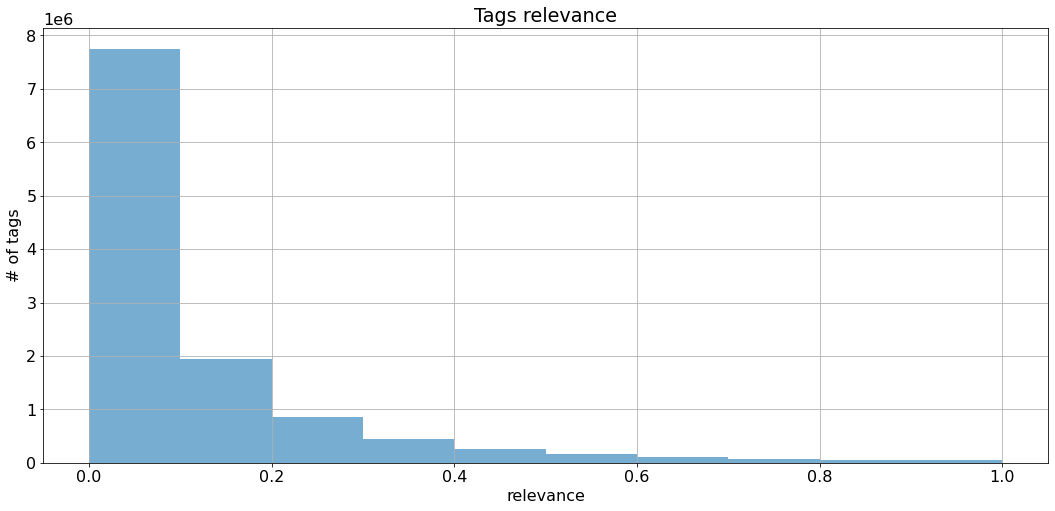

In [78]:
plt.hist(genome_scores['relevance'], alpha=0.6)

# add title and labels
plt.title('Tags relevance')
plt.xlabel('relevance')
plt.ylabel('# of tags')

# add grid
plt.grid()

The relevance of the tags is generally very low. Due to that they can reduce performance of the model. That is why we decided not to include this data into analysis.

A little bit of tidying data:
* Split genres
* Convert dataframe to a long format

In [12]:
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [13]:
columns = ['movieId', 'title', 'genres', 'year']
movies_long = pd.DataFrame(columns=columns)

#For every row in the dataframe, iterate through the list of genres and split it into rows
for index, row in movies_df.iterrows():
    for genre in row['genres']:
      movie_row = pd.DataFrame([[row['movieId'], row['title'], genre, row['year']]], columns=columns)
      movies_long = movies_long.append(movie_row)
   
movies_long.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure,1995
0,1,Toy Story,Animation,1995
0,1,Toy Story,Children,1995
0,1,Toy Story,Comedy,1995
0,1,Toy Story,Fantasy,1995


Now we need to obtain a list of all possible fatures with all possible values.

In [70]:
def get_item_features(features_df):
  item_feat_train = []
  uniq_genres = features_df.genres.unique()
  uniq_year = features_df.year.unique()
  col = ['genres']*len(uniq_genres) + ['year']*len(uniq_year)
  uniq_f = list(uniq_genres) + list(uniq_year)
  for x,y in zip(col, uniq_f):
      res = str(x)+ ":" +str(y)
      item_feat_train.append(res) 
  return item_feat_train

In [ ]:
movies_features_all = get_item_features(movies_long)
movies_features_all.head()

IMPORTANT ISSUE: Now we need to refit our dataset. In other words, we need to add feature information to already existing dataset.

In [77]:
# we call fit to supply userid, item id and user/item features
dataset_all.fit_partial(
        item_features = movies_features_all
)

Finally, we need to reformat our dataframe with movies with features into a list with tuples.



In [17]:
def feature_colon_value(my_list):
    """
    Takes as input a list and prepends the columns names to respective values in the list.
    For example: if my_list = [1,1,0,'del'],
    resultant output = ['f1:1', 'f2:1', 'f3:0', 'loc:del']
   
    """
    result = []
    ll = ['genres:','year:']
    aa = my_list
    for x,y in zip(ll,aa):
        res = str(x) +""+ str(y)
        result.append(res)
    return result

In [18]:
def create_feature_list(features_df):
  feature_list = []

  ad_subset = features_df[["genres", 'year']] 
  ad_list = [list(x) for x in ad_subset.values]

  for item in ad_list:
    feature_list.append(feature_colon_value(item))
  return feature_list

In [19]:
movies_lst_all = create_feature_list(movies_long)
movies_tuple_all = list(zip(movies_long.movieId, movies_lst_all))
movies_tuple_all[0:5]

[(1, ['genres:Adventure', 'year:1995']),
 (1, ['genres:Animation', 'year:1995']),
 (1, ['genres:Children', 'year:1995']),
 (1, ['genres:Comedy', 'year:1995']),
 (1, ['genres:Fantasy', 'year:1995'])]

Finally, we build *item_features* matrix from our dataset.

In [20]:
item_features_all = dataset_all.build_item_features(movies_tuple_all, normalize= False)

And rebuild interaction matrices for old and new data.

In [21]:
# plugging in the interactions and their weights
interactions_old, weights_old = dataset_all.build_interactions([(x[0], x[1], x[2]) for x in old_ratings.values])

In [22]:
# plugging in the interactions and their weights
interactions_new, weights_new = dataset_all.build_interactions([(x[0], x[1], x[2]) for x in new_ratings.values])

After all this data preparation, we are able to find best parameters!

## Parameters tuning

Again, we need to find optimal parameters. Be aware, it can take ~7 hours.

In [90]:
train_interactions, valid_interactions = random_train_test_split(interactions_old, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights, valid_weights = random_train_test_split(weights_old, test_percentage=0.2, random_state=np.random.RandomState(3))

In [ ]:
def objective(params):
    # unpack
    epochs, learning_rate, no_components, alpha = params
    
    user_alpha = alpha
    item_alpha = alpha
    model = LightFM(loss='warp',
                    random_state=42,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    
    model.fit(train_interactions,
              item_features=item_features_all,
              sample_weight=train_weights,
              epochs=epochs,
              num_threads=4, verbose=True)
    
    patks = precision_at_k(model, valid_interactions, item_features=item_features_all, k=10, num_threads=4)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [ ]:
space_hyb = [(1, 30), # epochs
         (10**-4, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-6, 10**-1, 'log-uniform'), # alpha
        ]

res_fm_hyb = forest_minimize(objective, space_hyb, n_calls=15,
                     random_state=0,
                     verbose=True)

In [ ]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm_hyb.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm_hyb.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.09400
Optimal parameters:
epochs: 19
learning_rate: 0.007842096480821407
no_components: 197
alpha: 0.00020295362430434758


The best parameters are:

In [23]:
epochs = 19
learning_rate = 0.007842096480821407
no_components = 197
alpha = 0.00020295362430434758

Again we need to fit a model with the best parameters using additioanl feature information.

In [24]:
best_model_hyb = LightFM(loss='warp',
                    random_state=42,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=alpha,
                    item_alpha=alpha)

In [25]:
best_model_hyb.fit(interactions_old,
               item_features=item_features_all,
               sample_weight=weights_old,
               epochs=epochs,
               num_threads=4, verbose=True)

Epoch: 100%|██████████| 19/19 [24:41<00:00, 77.98s/it]


In [ ]:
train_precisions_best_hyb = precision_at_k(best_model_hyb, interactions_old, item_features=item_features_all, k=5, num_threads=4)

In [29]:
test_precisions_best_hyb = precision_at_k(model=best_model_hyb, 
                                      test_interactions=interactions_new, 
                                      train_interactions=interactions_old,
                                      item_features=item_features_all,
                                      k=5, 
                                      num_threads=4)

In [30]:
mean_train_precision_best_hyb = train_precisions_best_hyb.mean()
mean_test_precision_best_hyb = test_precisions_best_hyb.mean()

print('Precision@k: train %.2f, test %.2f.' % (mean_train_precision_best_hyb, mean_test_precision_best_hyb))

Precision@k: train 0.53, test 0.19.


Now let's look on both models and compare them.

Text(0.5, 1.0, 'Hybrid model')

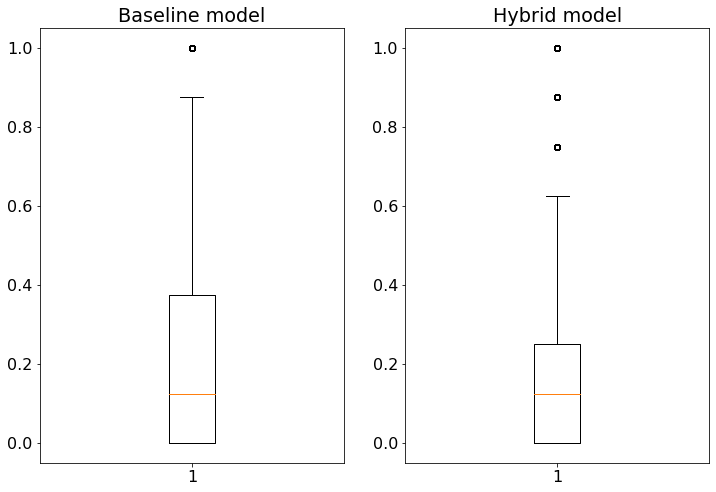

In [42]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.size'] = 16
figure, axes = plt.subplots(nrows = 1, ncols = 2)

# Next you could use each axes as plt
axes[0].boxplot(test_precisions_baseline)
axes[1].boxplot(test_precisions_best_hyb)

# Customization functions are slightly different - set_attribute
axes[0].set_title('Baseline model')
axes[1].set_title('Hybrid model')

The t-test measures whether the average score differs significantly across samples. If we observe a large p-value, for example greater than 0.05 or 0.1 then we cannot reject the null hypothesis of identical average scores.

**TO-DO**: Run cross-validation on the same train-validation splits and compare obtained precisions@k using bootstrapping or t-test

From individual precisions, we can see that they are almost equal. We can assume that there is no big difference between two models.

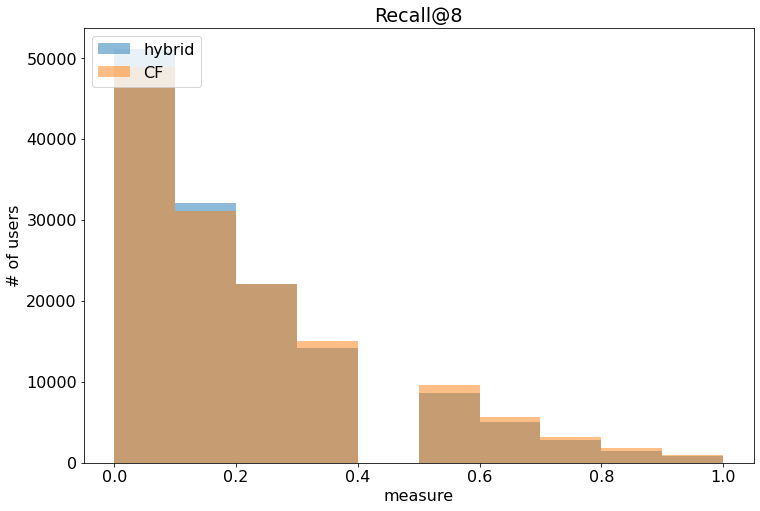

In [53]:
plt.hist(test_precisions_best_hyb, alpha=0.5, label='hybrid')
plt.hist(test_precisions_baseline, alpha=0.5, label='CF')

# add title and labels
plt.title('Recall@8')
plt.xlabel('measure')
plt.ylabel('# of users')

plt.legend(loc='upper left')

## Predictions for new movies

As I have said, hybrid systems can recommend new items based on additional features, not on average rating.

Let's find out how to make predictions for new items in *LightFM*

Firstly we need to get maps from our dataset:

In [78]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset_all.mapping()

Imagine we get 2 new movies:

In [63]:
columns = ['movieId', 'title', 'genres', 'year']
new_arrivals = pd.DataFrame([['88888000888', "Anacleto: Agente secreto", ['Crime', 'Thriller', 'Comedy'], '2015'],
                           ['88888000886', "Anabel", ['Action', 'Horror', 'Thriller'], '2015']], columns=columns)
new_arrivals

,movieId,title,genres,year
0,88888000888,Anacleto: Agente secreto,"[Crime, Thriller, Comedy]",2015
1,88888000886,Anabel,"[Action, Horror, Thriller]",2015


Let's format manually this toy dataframe:

In [64]:
columns = ['movieId', 'title', 'genres', 'year']
new_arrivals_long = pd.DataFrame(columns=columns)

#For every row in the dataframe, iterate through the list of genres and split it into rows
for index, row in new_arrivals.iterrows():
    for genre in row['genres']:
      movie_row = pd.DataFrame([[row['movieId'], row['title'], genre, row['year']]], columns=columns)
      new_arrivals_long = new_arrivals_long.append(movie_row)
   
new_arrivals_long.head()

,movieId,title,genres,year
0,88888000888,Anacleto: Agente secreto,Crime,2015
0,88888000888,Anacleto: Agente secreto,Thriller,2015
0,88888000888,Anacleto: Agente secreto,Comedy,2015
0,88888000886,Anabel,Action,2015
0,88888000886,Anabel,Horror,2015


In [72]:
new_arrivals_features = create_feature_list(new_arrivals_long)

In [79]:
new_arrivals_features

[['genres:Crime', 'year:2015'],
 ['genres:Thriller', 'year:2015'],
 ['genres:Comedy', 'year:2015'],
 ['genres:Action', 'year:2015'],
 ['genres:Horror', 'year:2015'],
 ['genres:Thriller', 'year:2015']]

In [74]:
def format_new_item_input(item_feature_map, new_item_feature_list):
  sp_data = []
  
  for item in new_item_feature_list:  
    num_features = len(item)
    normalised_val = 1.0 
    target_indices = []
    for feature in item:
      try:
          target_indices.append(item_feature_map[feature])
      except KeyError:
          print("new item feature encountered '{}'".format(feature))
          pass
    #print("target indices: {}".format(target_indices))
    new_user_features = np.zeros(len(item_feature_map.keys()))
    for i in target_indices:
      new_user_features[i] = normalised_val
    new_user_features = sparse.csr_matrix(new_user_features)
    sp_data.append(new_user_features)
  # Stack the matrix
  sp_data = sparse.vstack(sp_data)
  return sp_data

In [80]:
new_item_features_mx = format_new_item_input(item_feature_map, new_arrivals_features)

And finally we can make predictions of this film!

For example, we can obtain predicted ranks for these movies from user #59 from our dataset: 

In [83]:
best_model_hyb.predict(user_ids=59, item_ids=[0,1], item_features=new_item_features_mx)

array([-0.63200986, -0.61276054], dtype=float32)